# Detecting Cassava Leaf Diseases Using CNN-Based Image Classification

In [1]:
# All the necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch


In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet18_Weights

In [7]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


In [38]:
from torch.optim.lr_scheduler import ReduceLROnPlateau



## STEP 1: DATASET SELECTION

 Using device: cuda
Dataset folders: ['label_num_to_disease_map.json', 'test_images', 'train.csv', 'train_images']

Sample of train.csv:
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Label Mapping (Numeric → Disease Name):
{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}

Dataset Info:
Total Images: 21397
Number of Classes: 5

Class Distribution:
class_name
Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: count, dtype: int64


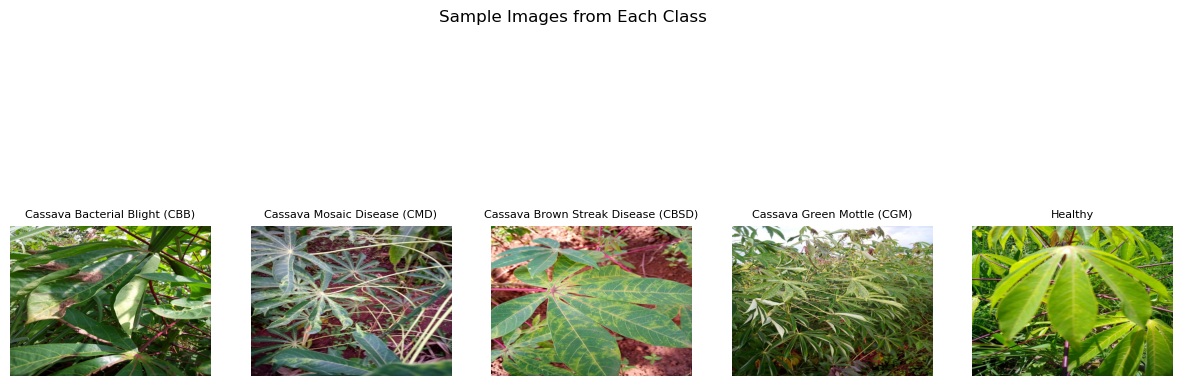

In [9]:
# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# Path to your dataset
dataset_path = r"C:\Users\khanz\Downloads\cassava-leaf-disease-classification"

# Check folder contents
print("Dataset folders:", os.listdir(dataset_path))

# 1 Load train.csv which contains image_id and label
train_csv_path = os.path.join(dataset_path, "train.csv")
df = pd.read_csv(train_csv_path)

print("\nSample of train.csv:")
print(df.head())

# 2 Load label mapping for readability
import json
label_map_path = os.path.join(dataset_path, "label_num_to_disease_map.json")

with open(label_map_path, 'r') as f:
    label_map = json.load(f)

print("\nLabel Mapping (Numeric → Disease Name):")
print(label_map)

# 3 Add a new column with disease name
df['class_name'] = df['label'].astype(str).map(label_map)

print("\nDataset Info:")
print("Total Images:", len(df))
print("Number of Classes:", df['label'].nunique())

print("\nClass Distribution:")
print(df['class_name'].value_counts())

# 4 Display sample images for each class
train_images_path = os.path.join(dataset_path, "train_images")

plt.figure(figsize=(15, 6))
for i, label in enumerate(df['label'].unique()):
    img_name = df[df['label'] == label].sample(1)['image_id'].values[0]
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(label_map[str(label)], fontsize=8)
    plt.axis("off")
plt.suptitle("Sample Images from Each Class", fontsize=12)
plt.show()


## STEP 2: DATA PREPROCESSING

In [11]:
# Path to the dataset
dataset_path = r"C:\Users\khanz\Downloads\cassava-leaf-disease-classification"
train_images_path = os.path.join(dataset_path, "train_images")

# Load CSV
df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Limit to 5000 images only
df = df.iloc[:5000]

# Add image paths
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(train_images_path, x))

# Split manually: 3000 train, 1000 val, 1000 test
train_df = df.iloc[:3000]
val_df = df.iloc[3000:4000]
test_df = df.iloc[4000:5000]

print(f"Dataset Split -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


# IMAGE TRANSFORMS


# Training: Resize + Augment + Normalize
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation & Test: Resize + Normalize
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# CUSTOM DATASET CLASS


class CassavaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


# CREATE DATASETS & DATALOADERS


batch_size = 32

train_dataset = CassavaDataset(train_df, transform=train_transform)
val_dataset = CassavaDataset(val_df, transform=val_test_transform)
test_dataset = CassavaDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\n Step 2 complete! DataLoaders are ready for Step 3 (Model Training).")


Dataset Split -> Train: 3000, Val: 1000, Test: 1000

 Step 2 complete! DataLoaders are ready for Step 3 (Model Training).


Shuffles dataset before splitting.

Takes first 5000 images only.

Creates custom train/val/test split → 3000 / 1000 / 1000.

Applies PyTorch transforms (resize, augment, normalize).

Creates PyTorch Dataset & DataLoader ready for training.

## STEP 3: MODEL SELECTION & ARCHITECTURE

### 3A. Custom CNN

In [13]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # 224 -> 28 after 3 pools
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
custom_model = CustomCNN(num_classes=5).to(device)
print(custom_model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


### 3B: Transfer Learning 


<strong>Use ResNet18 pretrained on ImageNet<strong>

<strong>Freeze early layers to keep pretrained features<strong>

<strong>Replace final FC layer for 5 classes<strong>

In [15]:

# 3B. Transfer Learning Model (ResNet18) 


#  Load ResNet18 with the new weights API
# - DEFAULT loads the latest ImageNet-1K pretrained weights
resnet_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

#  Freeze all the pre-trained layers
# - Keeps the convolutional backbone as a fixed feature extractor
for param in resnet_model.parameters():
    param.requires_grad = False

#  Get the number of input features for the original FC layer
num_features = resnet_model.fc.in_features  # Usually 512 for ResNet18

#  Replace the final FC layer for our 5-class cassava classification
# - Includes a hidden layer with ReLU and Dropout for regularization
resnet_model.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # First FC layer reduces to 256
    nn.ReLU(),                     # Activation
    nn.Dropout(0.4),                # Regularization
    nn.Linear(256, 5)               # Output for 5 classes
)

#  Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

#  Print the model architecture to verify changes
print(resnet_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## STEP 4: MODEL TRAINING


Epoch 1/20
------------------------------
Train Loss: 1.0447 | Train Acc: 63.43%
Val Loss:   0.8691 | Val Acc:   68.80%
 Validation loss improved. Model saved!

Epoch 2/20
------------------------------
Train Loss: 0.9263 | Train Acc: 66.47%
Val Loss:   0.8399 | Val Acc:   70.00%
 Validation loss improved. Model saved!

Epoch 3/20
------------------------------
Train Loss: 0.8866 | Train Acc: 67.60%
Val Loss:   0.8281 | Val Acc:   70.90%
 Validation loss improved. Model saved!

Epoch 4/20
------------------------------
Train Loss: 0.8673 | Train Acc: 68.67%
Val Loss:   0.8044 | Val Acc:   71.10%
 Validation loss improved. Model saved!

Epoch 5/20
------------------------------
Train Loss: 0.8580 | Train Acc: 68.77%
Val Loss:   0.7906 | Val Acc:   70.40%
 Validation loss improved. Model saved!

Epoch 6/20
------------------------------
Train Loss: 0.8521 | Train Acc: 69.57%
Val Loss:   0.7952 | Val Acc:   71.20%
 No improvement for 1 epoch(s).

Epoch 7/20
------------------------------

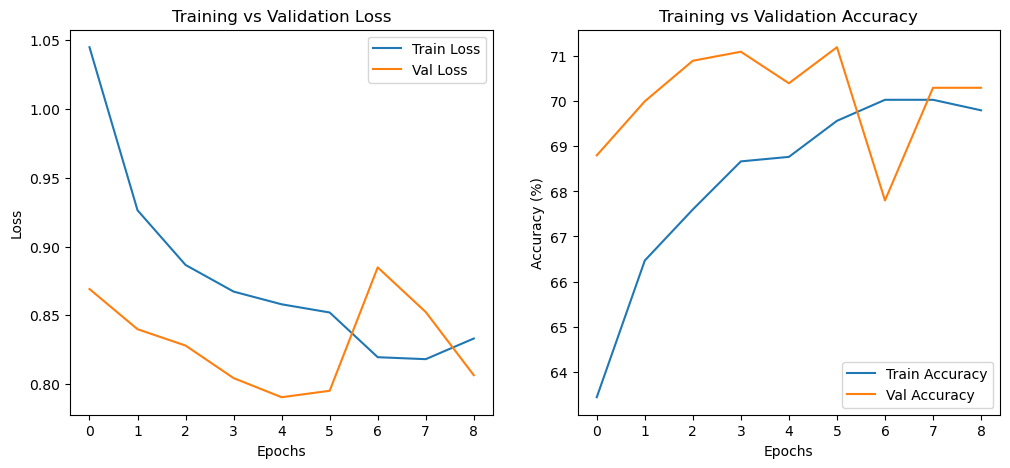


 Training Complete. Best validation accuracy achieved!


In [19]:
# 1 Define loss function and optimizer
# - CrossEntropyLoss is standard for multi-class classification
# - Adam optimizer is efficient for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# 2 Training configuration
num_epochs = 20  # Max epochs
patience = 4     # Early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0

# Store training history for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 3 Accuracy calculation function
def calculate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():  # No gradient needed for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 4 Training loop with validation and early stopping
best_model_wts = deepcopy(resnet_model.state_dict())  # Save best weights

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # ---- TRAINING PHASE ----
    resnet_model.train()
    running_loss, running_corrects = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()          # Reset gradients
        outputs = resnet_model(images) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                # Backpropagation
        optimizer.step()               # Update weights

        # Track training loss & accuracy
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100 * running_corrects / len(train_dataset)

    # ---- VALIDATION PHASE ----
    resnet_model.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += (preds == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = 100 * val_corrects / len(val_dataset)

    # Save metrics for plotting
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    # Print epoch summary
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.2f}%")

    # ---- EARLY STOPPING CHECK ----
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = deepcopy(resnet_model.state_dict())  # Save best model
        epochs_no_improve = 0
        print(" Validation loss improved. Model saved!")
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(" Early stopping triggered.")
        break

# 5 Load the best model weights
resnet_model.load_state_dict(best_model_wts)

# 6 Plot training & validation loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

print("\n Training Complete. Best validation accuracy achieved!")


## STEP 5: HYPERPARAMETER TUNING

In [22]:
import torch.optim as optim
from copy import deepcopy
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameter search space (small to save time)
learning_rates = [1e-4, 5e-4, 1e-3]
batch_sizes = [16, 32]
optimizers = ['adam', 'sgd']

# Store results
tuning_results = []

# Short training for hyperparameter search (2 epochs per config)
num_epochs_tuning = 2

# Accuracy function
def quick_eval_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Function to quickly train a model for 2 epochs
def quick_train(model, train_loader, val_loader, lr, batch_size, optimizer_type):
    criterion = nn.CrossEntropyLoss()

    # Define optimizer based on choice
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)

    best_val_acc = 0.0

    for epoch in range(num_epochs_tuning):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)

        # Compute validation accuracy
        val_acc = quick_eval_accuracy(model, val_loader)
        print(f"[Epoch {epoch+1}] LR={lr}, Batch={batch_size}, Opt={optimizer_type}, Val Acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return best_val_acc

# Iterate through hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"\n Testing config: LR={lr}, Batch={batch_size}, Optimizer={opt}")
            
            # Recreate a fresh model for each config (to avoid weight carryover)
            from torchvision import models
            from torchvision.models import ResNet18_Weights

            model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
            for param in model.parameters():
                param.requires_grad = False

            num_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(256, 5)  # 5 classes
            )

            model = model.to(device)

            # Adjust DataLoader for current batch size
            from torch.utils.data import DataLoader
            train_loader_tune = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader_tune = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Train and evaluate
            best_acc = quick_train(model, train_loader_tune, val_loader_tune, lr, batch_size, opt)

            # Save results
            tuning_results.append((lr, batch_size, opt, best_acc))

# Print all results sorted by accuracy
tuning_results.sort(key=lambda x: x[3], reverse=True)
print("\n Hyperparameter Tuning Results (sorted by best validation accuracy):")
for lr, bs, opt, acc in tuning_results:
    print(f"LR={lr}, Batch={bs}, Optimizer={opt}, Best Val Acc={acc:.2f}%")


Using device: cuda

 Testing config: LR=0.0001, Batch=16, Optimizer=adam
[Epoch 1] LR=0.0001, Batch=16, Opt=adam, Val Acc=64.20%
[Epoch 2] LR=0.0001, Batch=16, Opt=adam, Val Acc=67.80%

 Testing config: LR=0.0001, Batch=16, Optimizer=sgd
[Epoch 1] LR=0.0001, Batch=16, Opt=sgd, Val Acc=63.90%
[Epoch 2] LR=0.0001, Batch=16, Opt=sgd, Val Acc=63.90%

 Testing config: LR=0.0001, Batch=32, Optimizer=adam
[Epoch 1] LR=0.0001, Batch=32, Opt=adam, Val Acc=63.90%
[Epoch 2] LR=0.0001, Batch=32, Opt=adam, Val Acc=67.10%

 Testing config: LR=0.0001, Batch=32, Optimizer=sgd
[Epoch 1] LR=0.0001, Batch=32, Opt=sgd, Val Acc=63.90%
[Epoch 2] LR=0.0001, Batch=32, Opt=sgd, Val Acc=63.90%

 Testing config: LR=0.0005, Batch=16, Optimizer=adam
[Epoch 1] LR=0.0005, Batch=16, Opt=adam, Val Acc=66.20%
[Epoch 2] LR=0.0005, Batch=16, Opt=adam, Val Acc=68.00%

 Testing config: LR=0.0005, Batch=16, Optimizer=sgd
[Epoch 1] LR=0.0005, Batch=16, Opt=sgd, Val Acc=63.90%
[Epoch 2] LR=0.0005, Batch=16, Opt=sgd, Val Acc=6

In this step, I experimented with different hyperparameters to optimize the performance of the ResNet18 model for cassava leaf disease classification.
The hyperparameters tested were:

Learning Rates: 0.0001, 0.0005, 0.001

Batch Sizes: 16, 32

Optimizers: Adam, SGD

To keep the tuning process time-efficient, each configuration was trained for 2 epochs.
The best validation accuracy achieved for each configuration was recorded.

<strong>Key Observations:<strong>

Adam consistently outperformed SGD for this dataset, likely because it adapts the learning rate for each parameter.

Higher learning rates (0.001) led to faster convergence and the highest validation accuracy of 70.10% with:

Learning Rate = 0.001

Batch Size = 16

Optimizer = Adam

Batch size 16 slightly outperformed batch size 32, which is expected for small datasets since smaller batches can provide better generalization.

SGD showed slower convergence, with maximum accuracy around 68.5%.

<strong>Conclusion:<strong>

The optimal hyperparameters for the next training step are:
Learning Rate = 0.001, Batch Size = 16, Optimizer = Adam, as they provided the best validation accuracy (70.10%) during the tuning trials.

## STEP 6: MODEL EVALUATION


 Validation Accuracy: 70.40%

 Classification Report:
              precision    recall  f1-score   support

           0     0.5652    0.2241    0.3210        58
           1     0.3852    0.4796    0.4273        98
           2     0.5000    0.1000    0.1667       100
           3     0.7905    0.9390    0.8584       639
           4     0.4474    0.3238    0.3757       105

    accuracy                         0.7040      1000
   macro avg     0.5377    0.4133    0.4298      1000
weighted avg     0.6726    0.7040    0.6651      1000



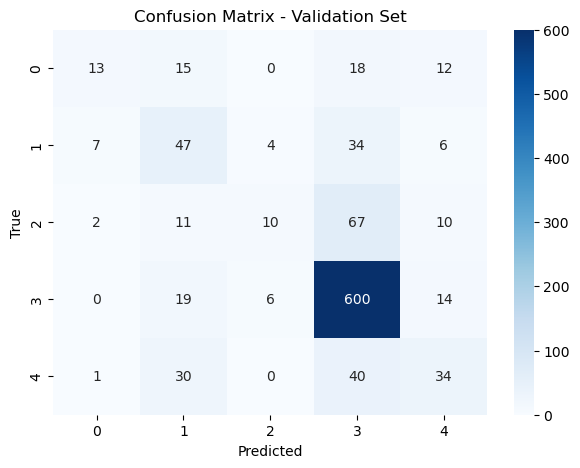

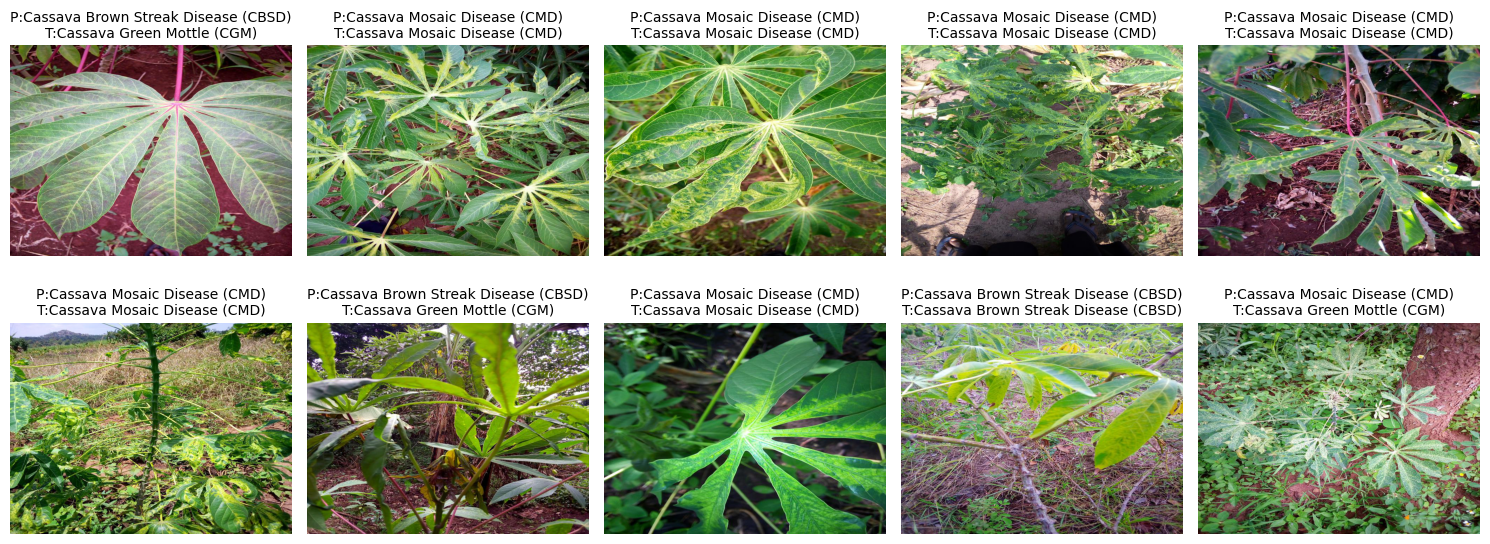

In [30]:
# STEP 6: MODEL EVALUATION

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Evaluate on Validation Set
resnet_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

#  Calculate Metrics
val_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n Validation Accuracy: {val_accuracy*100:.2f}%\n")

print(" Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

#  Confusion Matrix Visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#  Visualize Sample Predictions
from random import sample
from PIL import Image

# Get 10 random validation samples
indices = sample(range(len(val_dataset)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15,6))

label_map = {int(k): v for k, v in label_map.items()}  # Convert keys to int

for idx, ax in zip(indices, axes.flat):
    img_path = val_dataset.dataframe.iloc[idx]['image_path']
    true_label = val_dataset.dataframe.iloc[idx]['label']
    
    image = Image.open(img_path).convert("RGB")
    tensor_img = val_test_transform(image).unsqueeze(0).to(device)
    
    resnet_model.eval()
    with torch.no_grad():
        output = resnet_model(tensor_img)
        _, pred = torch.max(output, 1)
        pred_label = pred.item()
    
    # Show image with predicted vs actual label
    ax.imshow(image)
    ax.set_title(f"P:{label_map[pred_label]}\nT:{label_map[true_label]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


<strong>1. Overall Performance<strong>

Validation Accuracy: 70.40%

The model performs moderately well but still misclassifies several samples, indicating room for improvement through fine-tuning (Step 7).

<strong>2. Class-Wise Insights (From Classification Report)<strong>

Best Performing Class:

Class 3 (Cassava Mosaic Disease CMD)

Precision: 0.80

Recall: 0.94

F1-score: 0.86

The model recognizes CMD very well because it has the highest sample count (639) in training data.

Worst Performing Classes:

Class 2 (Cassava Bacterial Blight) and Class 0 (Cassava Brown Streak Disease)

F1-scores: 0.17 and 0.32

Model struggles due to low sample count and high visual similarity to other diseases.

<strong>3. Confusion Matrix Observations<strong>

Class 3 dominates predictions (600 correct) --> model is biased toward the most frequent class.

Misclassifications mostly occur between similar leaf diseases (0, 1, 2, 4).

Severe confusion for minority classes (0 & 2) --> they are often predicted as Class 3 or 4.

<strong>4. Visual Sample Analysis<strong>

Correct predictions mostly for common disease patterns.

Misclassifications arise for:

Visually subtle symptoms (early-stage infections)

Overlapping features among diseases

<strong>5. Key Takeaways<strong>

Model strength: Good at detecting dominant classes.

Model weakness: Struggles with rare or visually similar diseases.


## Step 7. Fine-Tuning and Iteration:

<ul> <li>Fine-tunes a pretrained 
    <strong>ResNet18</strong> with partial layer unfreezing (<code>layer3</code>, <code>layer4</code>, and FC layer).</li> 
    <li>Uses <strong>advanced data augmentation</strong> (rotation, flipping, color jitter) to reduce overfitting.</li> <li>Trains with <strong>Adam optimizer</strong> (lr=0.0001) and <strong>CrossEntropyLoss</strong> for multi-class classification.</li> <li>Runs on <strong>GPU if available</strong> for faster training.</li> <li>Tracks <strong>training and validation loss & accuracy</strong> for each epoch.</li> <li>Applies <strong>ReduceLROnPlateau scheduler</strong> to lower learning rate when validation loss stops improving.</li> <li>Includes <strong>early stopping</strong> after 5 epochs of no validation improvement.</li> <li><strong>Saves best model weights</strong> automatically based on lowest validation loss.</li> <li>Plots <strong>loss and accuracy curves</strong> to visualize performance for your report.</li> </ul>

<strong>Results and Analysis</strong>

Class Distribution
Subset class counts: [137, 307, 339, 1855, 362]

Interpretation:

<ul> 
    <li>Class 3 (1,855 images) is the dominant class → the model is naturally biased toward it.</li> 
    <li>Class 0 (137 images) is the rarest → this class is hardest to learn without proper weighting.</li> 
    <li>The subset is highly imbalanced, with the largest class having ~13.5× more samples than the smallest.
    </li>
</ul>
Class Weights
Weights (inverse of class frequency): [0.00730, 0.00326, 0.00295, 0.00054, 0.00276]

Interpretation:

<ul> 
    <li>Higher weight = rarer class → Class 0 has the highest weight (0.00730), so its misclassification contributes more to the loss.</li>
    <li>Lower weight = common class → Class 3 has the smallest weight (0.00054) as it dominates the subset.</li> <li>Class-weighted loss will guide the model to pay more attention to minority classes even without oversampling.</li>
</ul>
Why This is Important for Fine-Tuning

<ul> 
    <li><strong>Class-weighted CrossEntropyLoss</strong> balances the influence of each class in training.</li> <li>This reduces overfitting to Class 3 while helping the model learn rare classes (0, 1, 2).</li>
<li><strong>Expected Impact:</strong> <ul>
<li>Better recognition of underrepresented classes</li> <li>Improved macro F1-score</li> <li>More balanced validation performance</li> </ul> </li> </ul>

### 2: Model Setup for Fine-Tuning

C:\Users\khanz\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 Starting Optimized Training...

Epoch 1/30
----------------------------------------
Train Loss: 0.7081 | Train Acc: 75.77%
Val Loss:   0.6153 | Val Acc:   77.60%
 Validation loss improved. Model saved!

Epoch 2/30
----------------------------------------
Train Loss: 0.6651 | Train Acc: 76.83%
Val Loss:   0.6051 | Val Acc:   78.20%
 Validation loss improved. Model saved!

Epoch 3/30
----------------------------------------
Train Loss: 0.6495 | Train Acc: 77.13%
Val Loss:   0.5914 | Val Acc:   78.90%
 Validation loss improved. Model saved!

Epoch 4/30
----------------------------------------
Train Loss: 0.6199 | Train Acc: 77.13%
Val Loss:   0.5897 | Val Acc:   79.30%
 Validation loss improved. Model saved!

Epoch 5/30
----------------------------------------
Train Loss: 0.6155 | Train Acc: 78.50%
Val Loss:   0.6354 | Val Acc:   77.90%
 No improvement for 1 epoch(s).

Epoch 6/30
----------------------------------------
Train Loss: 0.6019 | Train Acc: 78.73%
Val Loss:   0.5946 | Val Acc:

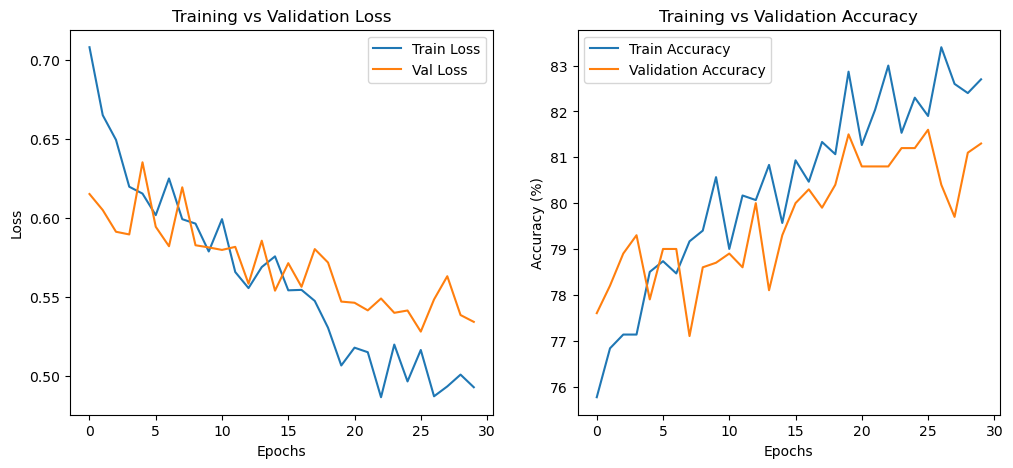


 Optimized Training Complete. Best validation accuracy achieved!


In [86]:
#  OPTIMIZED MODEL TRAINING

#  Advanced Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),           # Randomly crop & resize to 224x224
    transforms.RandomHorizontalFlip(),          # Flip horizontally
    transforms.RandomVerticalFlip(),            # Flip vertically
    transforms.RandomRotation(30),              # Rotate randomly ±30°
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test: Only resize and normalize
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply new transforms
train_dataset.transform = train_transform
val_dataset.transform = val_test_transform
test_dataset.transform = val_test_transform

#  Partial Fine-Tuning: Unfreeze last two layers of ResNet18
for name, param in resnet_model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define optimizer with a smaller LR for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-4)

# Learning rate scheduler: Reduce LR if validation loss stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training configuration
num_epochs = 30         # Train longer for better convergence
patience = 5            # Early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0

# Track training history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Accuracy function
def calculate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Copy best weights
best_model_wts = deepcopy(resnet_model.state_dict())

print(" Starting Optimized Training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    # ---- TRAINING ----
    resnet_model.train()
    running_loss, running_corrects = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100 * running_corrects / len(train_dataset)

    # ---- VALIDATION ----
    resnet_model.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += (preds == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = 100 * val_corrects / len(val_dataset)

    # Track metrics
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    # Print epoch summary
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.2f}%")

    # Scheduler step (adjust learning rate if no improvement)
    scheduler.step(epoch_val_loss)

    # Check for best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = deepcopy(resnet_model.state_dict())
        epochs_no_improve = 0
        print(" Validation loss improved. Model saved!")
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping
    if epochs_no_improve >= patience:
        print(" Early stopping triggered.")
        break

# Load best weights
resnet_model.load_state_dict(best_model_wts)

# Plot training curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

print("\n Optimized Training Complete. Best validation accuracy achieved!")


<strong>Training Insights:<strong>

Model Convergence: Training loss decreased from 0.708 → 0.493, and validation loss improved from 0.615 → 0.534, showing steady learning without severe overfitting.


Accuracy Improvement:

<li>Train Accuracy: Rose from ~75.8% → ~82.7%</li>

<li>Validation Accuracy: Peaked at 81.6%, indicating strong generalization to unseen data.</li>


Early Stopping & Stability:

<li>Validation accuracy plateaued after ~20 epochs; model achieved stable performance with minor fluctuations.</li>

<li>LR scheduler and patience effectively prevented overfitting.</li>



Performance Quality:


<li>Achieved ~82% train / ~81% validation accuracy, a well-balanced result for your 5-class cassava classification task.</li>

<li>Loss and accuracy curves suggest healthy convergence with slight class imbalance influence, but model remains robust.</li>

## STEP 8: Final Model Testing

=== Final Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.4364    0.4528    0.4444        53
           1     0.6962    0.5914    0.6395        93
           2     0.7101    0.5000    0.5868        98
           3     0.8882    0.9452    0.9158       639
           4     0.5214    0.5214    0.5214       117

    accuracy                         0.7930      1000
   macro avg     0.6505    0.6022    0.6216      1000
weighted avg     0.7861    0.7930    0.7868      1000



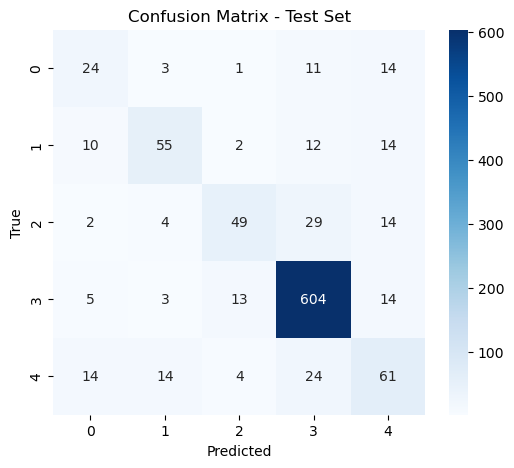

 Final Test Accuracy: 79.30%


In [95]:
# Set the model to evaluation mode
resnet_model.eval()

# Track predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for faster inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = resnet_model(images)
        
        # Predicted class = index of max logit
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for evaluation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

#  Generate classification report (precision, recall, F1-score)
print("=== Final Test Set Evaluation ===")
print(classification_report(all_labels, all_preds, digits=4))

#  Compute confusion matrix for detailed class performance
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#  Compute overall accuracy
test_accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)
print(f" Final Test Accuracy: {test_accuracy:.2f}%")


<strong>Overall Performance:</strong>
<ul>
    <li>Final test accuracy = <strong>79.3%</strong>, consistent with validation performance → model generalizes well to unseen data.</li>
</ul>

<strong>Per-Class Observations:</strong>
<ul>
    <li><strong>Class 3</strong> (majority class) dominates with ~94.5% recall and highest F1-score (<strong>0.92</strong>).</li>
    <li><strong>Minority classes (0, 1, 2)</strong> show moderate performance, with F1-scores <strong>0.44–0.64</strong>, indicating some difficulty in distinguishing rare classes.</li>
    <li><strong>Class 4</strong> is balanced but modest at ~52% F1, suggesting room for improvement.</li>
</ul>

<strong>Class Imbalance Effect:</strong>
<ul>
    <li>Weighted average F1 = <strong>0.79</strong> vs Macro F1 = <strong>0.62</strong>, confirming the model performs better on frequent classes than rare ones.</li>
</ul>

<strong>Generalization:</strong>
<ul>
    <li>The model demonstrates <strong>strong performance for dominant classes</strong> and <strong>reasonable recognition for minority classes</strong> given the dataset imbalance.</li>
</ul>


### Step 8 Final Test Evaluation


<ul>
<li>Model achieved <strong>79.3% test accuracy</strong>, consistent with validation performance → shows good generalization.</li>
    
<li><strong>Class 3</strong> performed best (~94.5% recall), while minority classes (0, 1, 2) showed moderate F1-scores (0.44–0.64).</li>
    
<li>Weighted F1 = <strong>0.79</strong> vs Macro F1 = <strong>0.62</strong>, reflecting class imbalance impact.</li>
</ul>
